In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [2]:
base_grande = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')
base_grande.shape
base_grande = base_grande.dropna()
base_grande = pd.get_dummies(base_grande, prefix = 'indicatrice_', columns=['patho_niv1'], dtype='int')


liste_var = base_grande.columns[17:]
liste_bis = []
for i in liste_var : 
    liste_bis.append(i)
indicatrice_patho_niv1 = liste_bis

liste_auxil = base_grande['cla_age_5'].unique()
inter_excl = ('95et+', 'tsage', np.nan)

inter_def = []
for i in liste_auxil :
    if i in inter_excl : 
        inter_def = inter_def
    else : 
        inter_def.append(i)
classe_age = []
for i in base_grande['cla_age_5'] : 
    if i in inter_def :
        temp = i.split('-')
        temp[0] = int(temp[0])
        temp[1] = int(temp[1])
        age = (temp[1] + temp[0])/2
    elif i == 'tsage' : 
        age = np.nan
    elif i == '95et+' : 
        age = 100
    else : 
        age = np.nan
    classe_age.append(age)
base_grande.loc[:,'classe_age'] = classe_age

In [21]:
base_grande.head()

,annee,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,dept,ntop,npop,...,indicatrice__Maladies du foie ou du pancréas (hors mucoviscidose),indicatrice__Maladies inflammatoires ou rares ou VIH ou SIDA,indicatrice__Maladies neurologiques ou dégénératives,indicatrice__Maladies psychiatriques,indicatrice__Maladies respiratoires chroniques (hors mucoviscidose),indicatrice__Maternité (avec ou sans pathologies),indicatrice__Séjours en hospitalisation complète pour prise en charge de la Covid-19,indicatrice__Traitements du risque vasculaire (hors pathologies),indicatrice__Traitements psychotropes (hors pathologies),classe_age
0,2020.0,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,1,971,290.0,4210.0,...,0,0,0,0,0,0,0,1,0,82.0
1,2020.0,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,3,973,40.0,650.0,...,0,0,0,0,0,0,0,1,0,82.0
2,2020.0,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,4,999,410.0,5630.0,...,0,0,0,0,0,0,0,1,0,82.0
3,2020.0,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,6,999,20.0,350.0,...,0,0,0,0,0,0,0,1,0,82.0
4,2020.0,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11,75,2960.0,20820.0,...,0,0,0,0,0,0,0,1,0,82.0


In [22]:
model_resp_alpha = base_grande[['dept', 'classe_age','indicatrice__Maladies respiratoires chroniques (hors mucoviscidose)','sexe','region']]

In [23]:
model_resp_alpha.columns = model_resp_alpha.columns.str.replace(' ', '_')

In [24]:
resultats = model_resp_alpha[model_resp_alpha['indicatrice__Maladies_respiratoires_chroniques_(hors_mucoviscidose)'] == 1].groupby('classe_age').size()
resultats

classe_age
2.0      2520
7.0      2520
12.0     2520
17.0     2520
22.0     2512
27.0     2518
32.0     2520
37.0     2520
42.0     2520
47.0     2520
52.0     2520
57.0     2520
62.0     2520
67.0     2520
72.0     2520
77.0     2520
82.0     2520
87.0     2504
92.0     2480
100.0    2454
dtype: int64

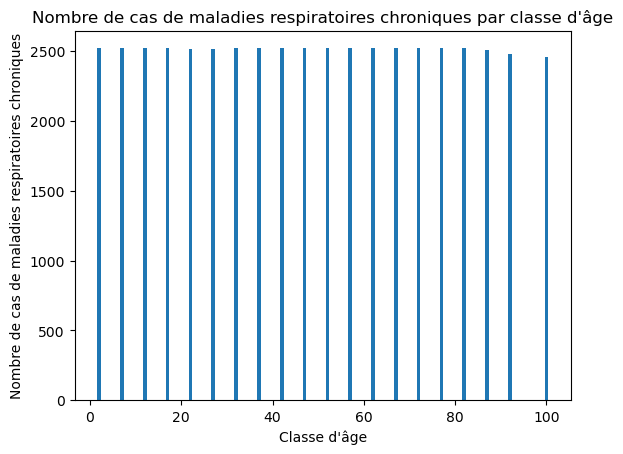

In [25]:
# Filtrez les lignes où la colonne 'indicatrice__Maladies_respiratoires_chroniques_(hors_mucoviscidose)' est égale à 1
T_filtered = model_resp_alpha[model_resp_alpha['indicatrice__Maladies_respiratoires_chroniques_(hors_mucoviscidose)'] == 1]

# Agrégation par âge pour compter le nombre d'individus
agg_data = T_filtered.groupby('classe_age').size().reset_index(name='nombre_de_cas')

# Créez un histogramme
plt.bar(agg_data['classe_age'], height=agg_data['nombre_de_cas'])

# Ajoutez des étiquettes et un titre
plt.xlabel('Classe d\'âge')
plt.ylabel('Nombre de cas de maladies respiratoires chroniques')
plt.title('Nombre de cas de maladies respiratoires chroniques par classe d\'âge')

# Affichez l'histogramme
plt.show()